In [1]:
### Set up directory
import sys
import os
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

# Check if directory exists, if not create it
save_path = os.path.join(parent_dir, 'generated_series_RL')
if not os.path.exists(save_path):
    os.makedirs(save_path)
    
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import os
from data.serialize import serialize_arr, deserialize_str, SerializerSettings
import pickle
from scipy.integrate import odeint


def serialize_gaussian(prec, time_series, mean_series, sigma_series):
    """
    Serialize a time series with gaussian noise and continuous support.

    Parameters:
    prec (int): Precision of the serialization
    time_series (list): The time series data
    mean_series (list): The mean series data
    sigma_series (list): The sigma series data

    Returns:
    tuple: A tuple containing 
        serialized time series: str
        rescaled mean series: np array
        rescaled sigma series: np array
    """
    settings=SerializerSettings(base=10, prec=prec, signed=True, time_sep=',', bit_sep='', minus_sign='-', fixed_length=False, max_val = 10)
    time_series = np.array(time_series)
    ### Final range is from 0.15 to 0.85
    rescale_factor = 7.0
    up_shift = 1.5

    rescaled_array = (time_series-time_series.min())/(time_series.max()-time_series.min()) * rescale_factor + up_shift
    rescaled_true_mean_arr = (np.array(mean_series)-time_series.min())/(time_series.max()-time_series.min()) * rescale_factor + up_shift
    rescaled_true_sigma_arr = np.array(sigma_series)/(time_series.max()-time_series.min()) * rescale_factor 
    # rescaled_true_mean_arr *= 10
    # rescaled_true_sigma_arr *= 10
    full_series = serialize_arr(rescaled_array, settings)
    return (full_series, rescaled_true_mean_arr, rescaled_true_sigma_arr)

def generate_transition_matrix(N_state):
    """
    Generate a random transition matrix of shape (N_state, N_state).
    Each row sums to 1.
    """
    P = np.random.rand(N_state, N_state)
    P /= P.sum(axis=1)[:, np.newaxis]
    return P

def generate_gaussian_matrix(N_state, sigma = 0.5):
    """
    Generate a transition matrix of shape (N_state, N_state) for an uncorrelated Brownian motion.
    Each row will be the same, representing discretized bins of a Gaussian distribution.
    The sum of each row is normalized to 1.

    :param N_state: Number of states (and thus size of the transition matrix)
    :param sigma: Standard deviation of the Gaussian distribution (controls the width of the Gaussian)
    """
    # Define the bins for the Gaussian distribution
    bins = np.linspace(-3, 3, N_state)
    
    # Calculate the Gaussian distribution values for these bins
    gaussian_distribution = np.exp(-0.5 * (bins / sigma) ** 2)
    gaussian_distribution /= gaussian_distribution.sum()  # Normalize to sum to 1

    # Repeat this distribution for each row to create the transition matrix
    P = np.tile(gaussian_distribution, (N_state, 1))

    return P

In [2]:
import gymnasium as gym
from copy import copy

### Generate Series with Continuous Support

In [3]:
num_series = 1
llama_size = '13b'
# mode = 'neighbor'
# prec = 3
# refine_depth = 2
# mode = 'all'
# prec = 2
# refine_depth = 0
mode = 'neighbor'
prec = 2
refine_depth = 1

random_seed:  7
arr: shape | (1000,), sample | [7.78572916 7.98577358 7.93063797 7.93452167 7.98274416 7.88938879
 7.88963321 7.88952785 7.68188663 7.80230882]
sign_arr: shape | (1000,), sample | [1 1 1 1 1 1 1 1 1 1]
digits_arr: shape | (1000, 3), sample | [[7 7 8]
 [7 9 8]
 [7 9 3]
 [7 9 3]
 [7 9 8]
 [7 8 8]
 [7 8 8]
 [7 8 8]
 [7 6 8]
 [7 8 0]]
bit_str (list): shape | 1000, sample | ['778', '798', '793', '793', '798', '788', '788', '788', '768', '780']
bit_str: shape | 4000, sample | 778,798,79


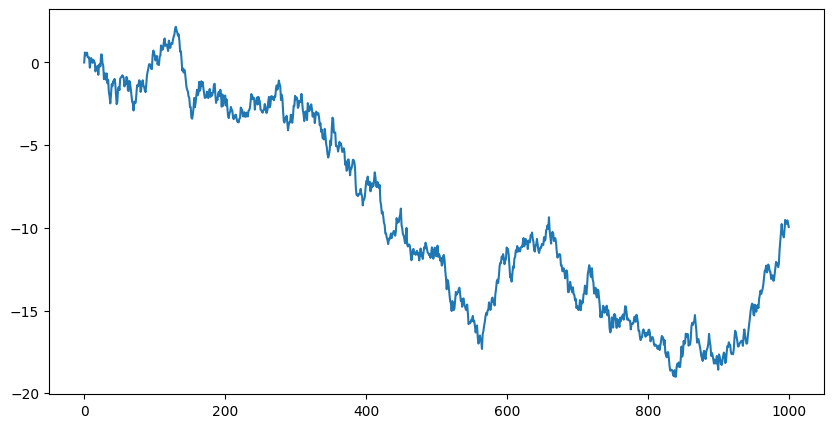

In [16]:
####################################
### Generate continuous time series
####################################

### Brownian Motion



traj_name = 'brownian_motion'
Nt = 1000 # number of steps
a = 0 # drift

# other hyper-parameters
dt =  0.2 # time step
tspan = np.linspace(0, Nt*dt, Nt)
sigma = 0.8

for traj_idx in range(num_series):
    random_seed = 7+traj_idx
    print("random_seed: ", random_seed)
    np.random.seed(random_seed)
    # Initialize the time series
    x = 0  # Starting point
    time_series = [x]
    mean_series = [x]
    sigma_series = [0]

    # Generate the drift-diffusion time series
    for t in range(1, Nt):
        x_mean = x + a*dt
        x_sigma = sigma * np.sqrt(dt)
        dW =  np.random.normal()  # Wiener process (Brownian motion)
        x = x_mean + x_sigma * dW
        
        time_series.append(x)
        mean_series.append(x_mean)
        sigma_series.append(x_sigma)

    full_series, rescaled_true_mean_arr, rescaled_true_sigma_arr = serialize_gaussian(prec, time_series, mean_series, sigma_series)
    
    plt.figure(figsize=(10, 5))
    plt.plot(time_series, alpha = 1, label='time_series')
    # plt.plot(full_series, alpha = 1, label='full_series')
    plt.show()
    
    # Save the generated data to a dictionary
    data_dict = {
        'full_series': full_series,
        'rescaled_true_mean_arr': rescaled_true_mean_arr,
        'rescaled_true_sigma_arr': rescaled_true_sigma_arr,
        'prec': prec,
        'llama_size': llama_size,
        'mode': mode,
        'refine_depth': 1,
        'random_seed': 7,
        'time_series': np.array(time_series)
    }

    # Pickle and save the dictionary
    # Count existing files in the save_path and assign a new number
    file_indices = [int(name[:-4].rsplit('_',1)[1]) for name in os.listdir(save_path) if os.path.isfile(os.path.join(save_path, name)) and name.startswith(traj_name)]
    file_indices += [-1]
    save_name = os.path.join(save_path, f'{traj_name}_{max(file_indices)+1}.pkl')
    with open(save_name, 'wb') as f:
        pickle.dump(data_dict, f)


In [17]:
len(full_series)

4000

# series from Gym-environment: Halfcheetah

## only observations + random policy

arr: shape | (1000,), sample | [7.61338315 7.29580614 6.9969203  6.58058552 5.72545037 5.15506567
 5.53902865 6.27438579 6.63719547 6.9185971 ]
sign_arr: shape | (1000,), sample | [1 1 1 1 1 1 1 1 1 1]
digits_arr: shape | (1000, 3), sample | [[7 6 1]
 [7 2 9]
 [6 9 9]
 [6 5 8]
 [5 7 2]
 [5 1 5]
 [5 5 3]
 [6 2 7]
 [6 6 3]
 [6 9 1]]
bit_str (list): shape | 1000, sample | ['761', '729', '699', '658', '572', '515', '553', '627', '663', '691']
bit_str: shape | 4000, sample | 761,729,69
arr: shape | (1000,), sample | [1.92624594 1.81924925 1.84616233 1.94366432 1.95283792 1.84860516
 1.90298012 2.1692163  2.34740054 2.39683488]
sign_arr: shape | (1000,), sample | [1 1 1 1 1 1 1 1 1 1]
digits_arr: shape | (1000, 3), sample | [[1 9 2]
 [1 8 1]
 [1 8 4]
 [1 9 4]
 [1 9 5]
 [1 8 4]
 [1 9 0]
 [2 1 6]
 [2 3 4]
 [2 3 9]]
bit_str (list): shape | 1000, sample | ['192', '181', '184', '194', '195', '184', '190', '216', '234', '239']
bit_str: shape | 4000, sample | 192,181,18
arr: shape | (1000,), sample

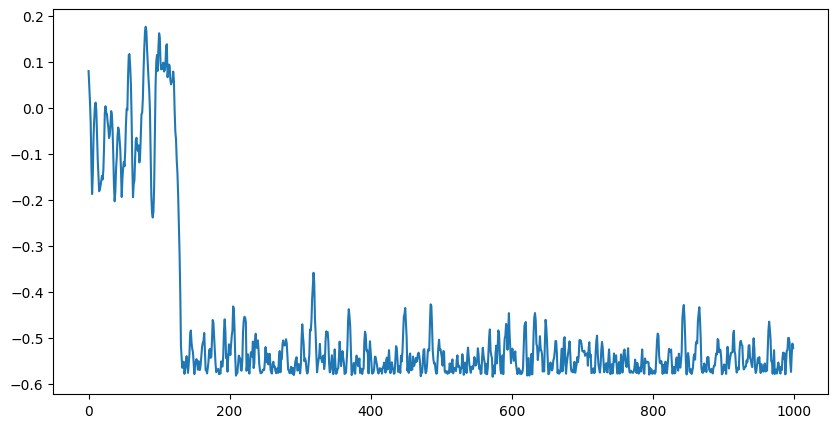

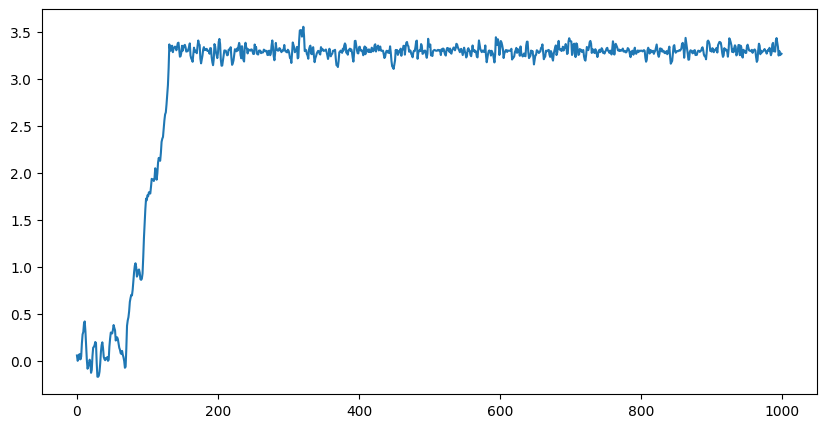

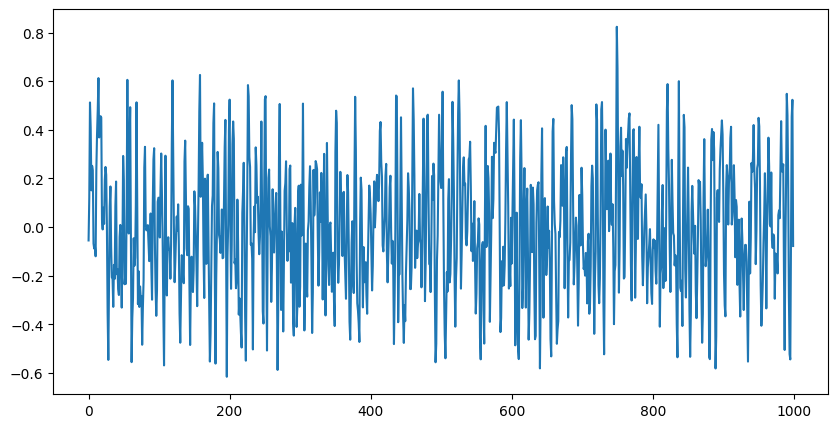

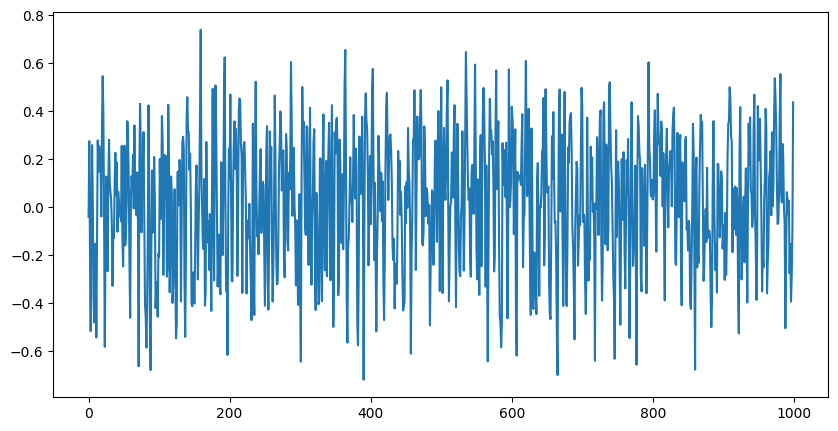

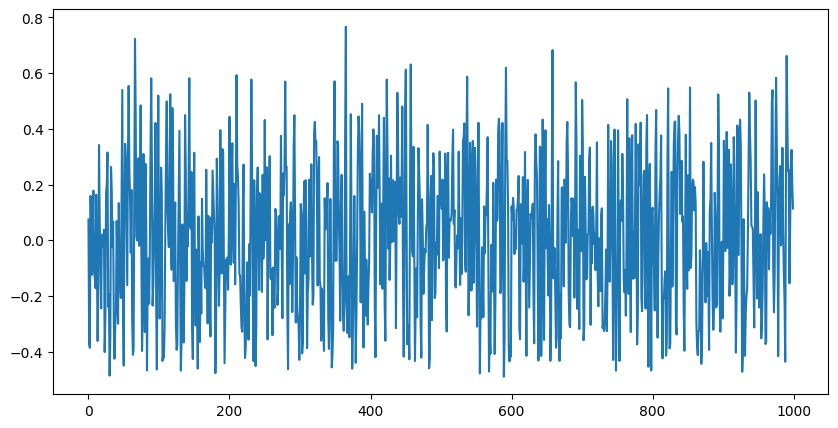

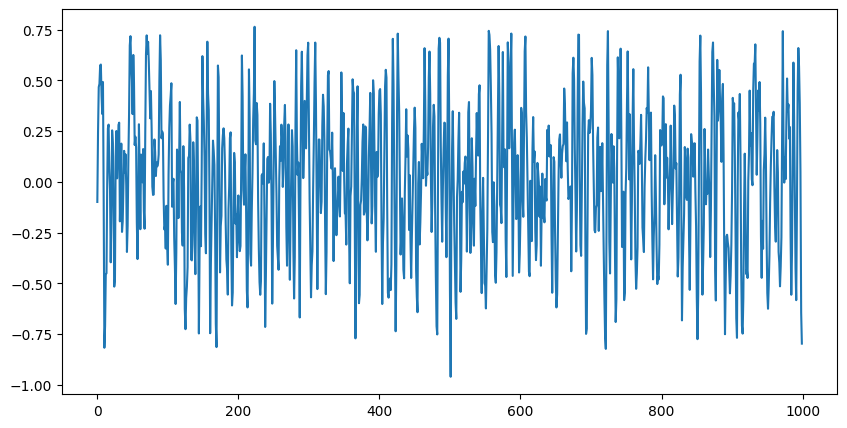

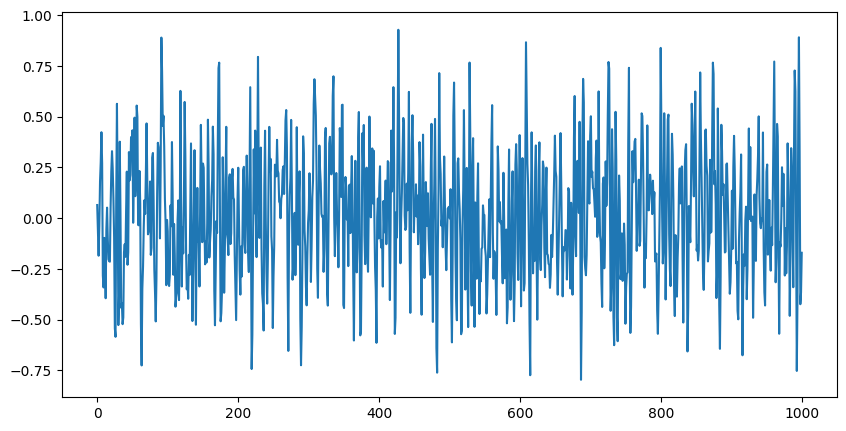

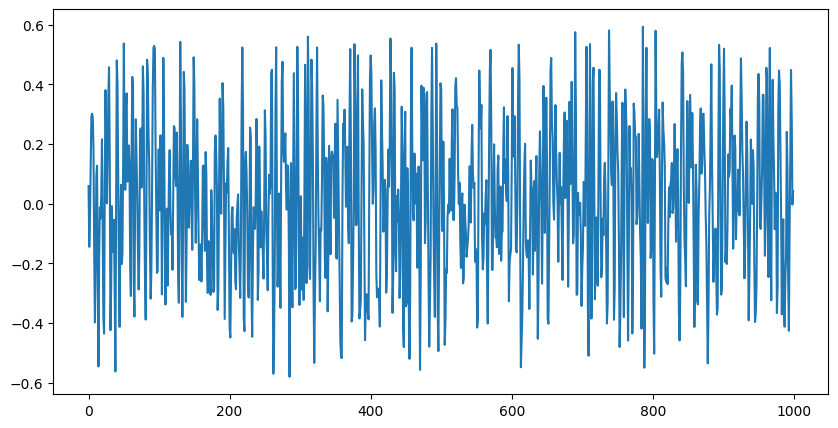

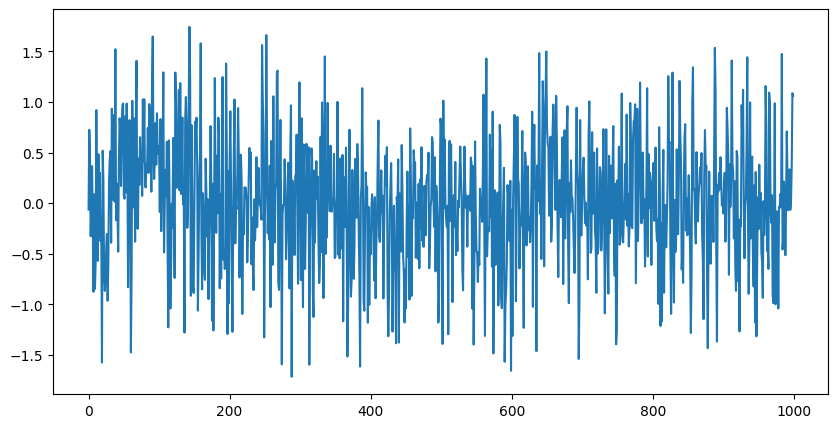

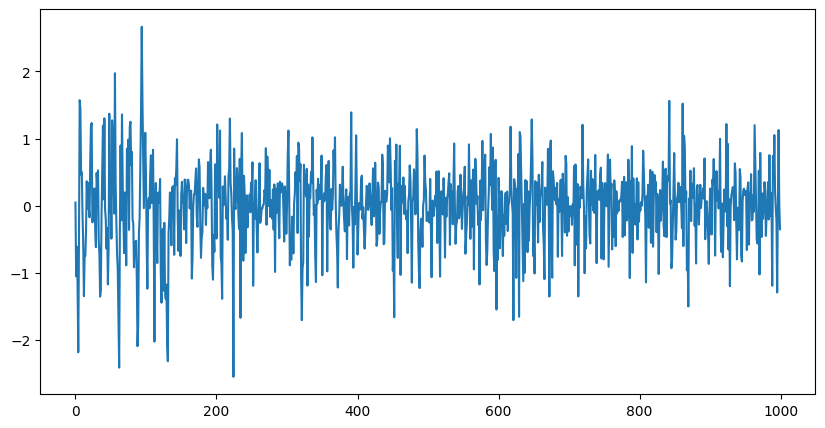

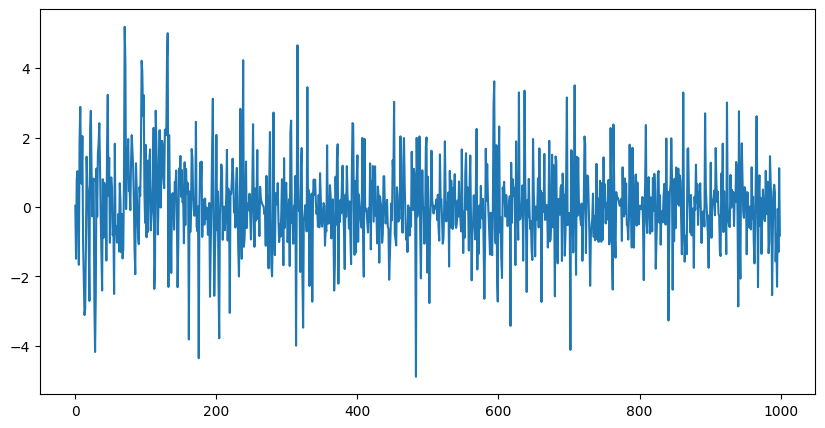

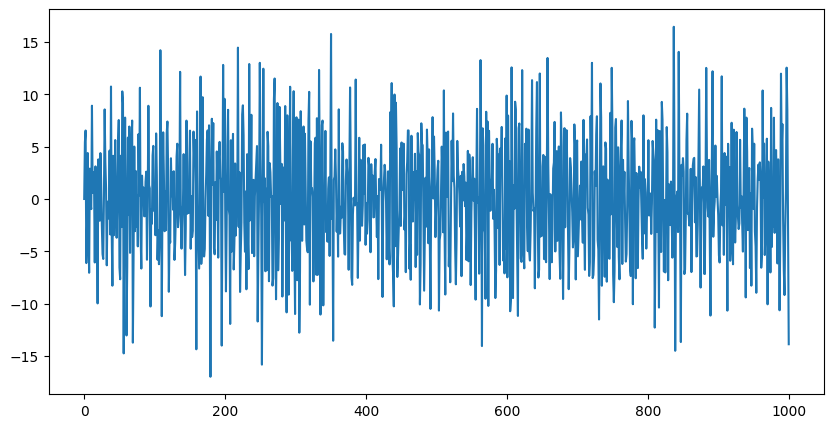

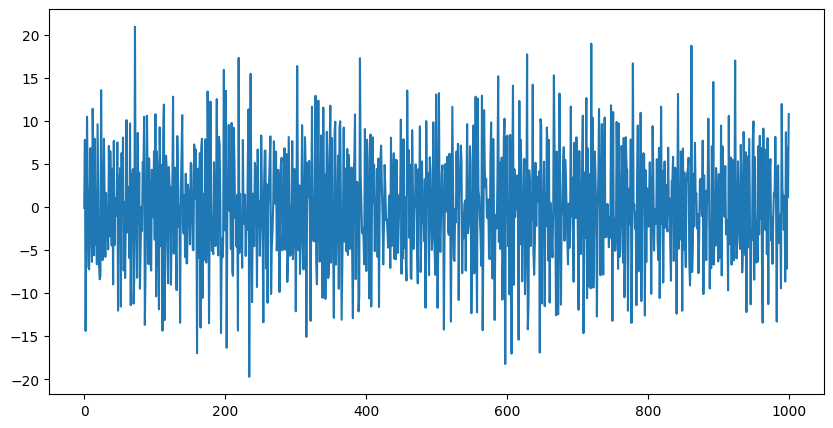

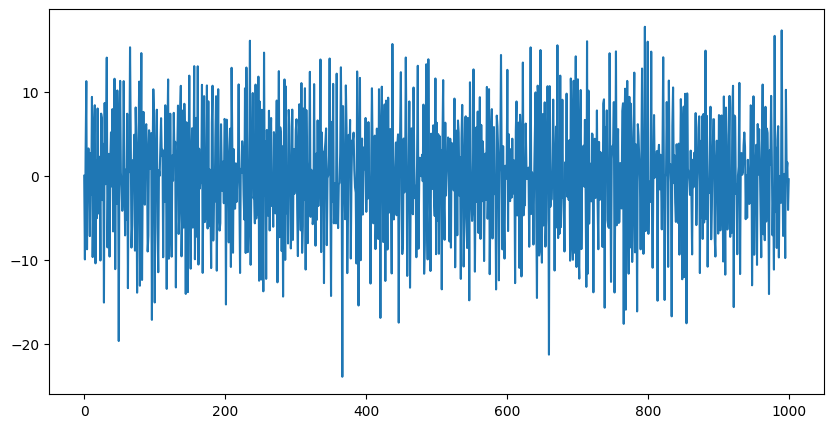

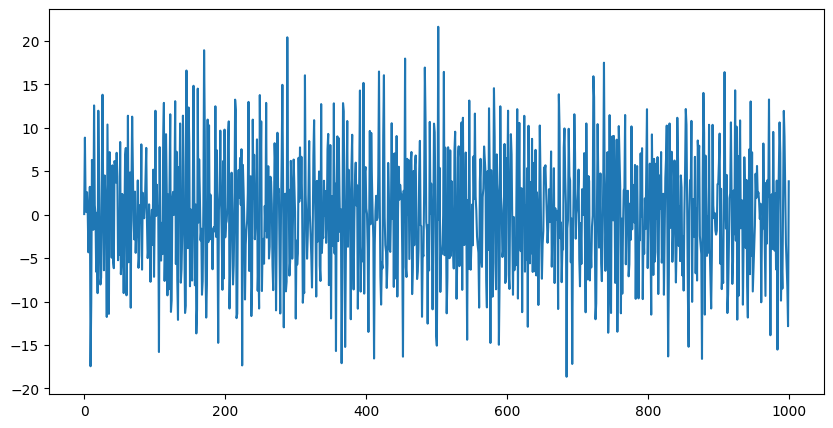

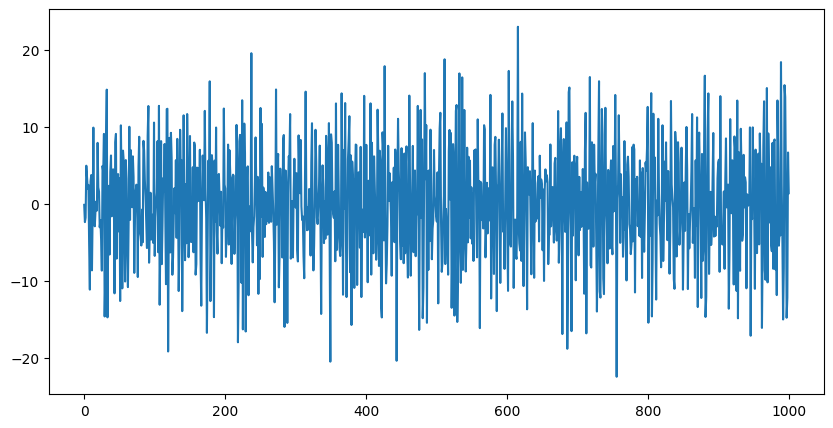

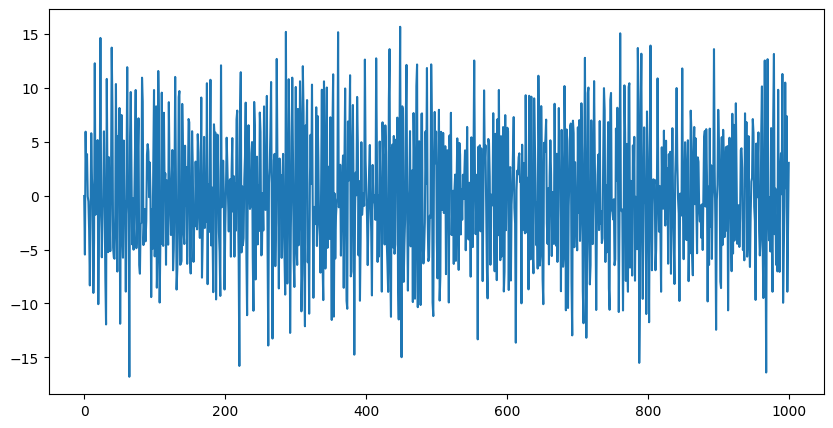

In [18]:
####################################
### Generate continuous time series
####################################

### Halfcheetah + random policy

traj_name = 'gym_halfcheetah_all'
Nt = 1000 # number of steps

env = gym.make('HalfCheetah')

seed = 7
env.np_random.__setstate__(np.random.default_rng(seed).__getstate__())

obs, _ = env.reset()

time_series = [obs]
mean_series = [obs]
sigma_series = [0]
# Generate the episode
for t in range(1, Nt):
    action = env.action_space.sample()
    next_obs, reward, terminated, truncated, info = env.step(action)
    time_series.append(next_obs)
    mean_series.append(next_obs)
    sigma_series.append(0)

episode_time_series = np.stack(time_series, axis=0)
        
for obs_dim in range(env.observation_space.shape[0]):
    time_series = episode_time_series[:, obs_dim]
    mean_series = copy(time_series)
    std_series = 0.1*np.ones_like(mean_series)
    
    full_series, rescaled_true_mean_arr, rescaled_true_sigma_arr = serialize_gaussian(prec, time_series, mean_series, sigma_series)
    
    plt.figure(figsize=(10, 5))
    plt.plot(time_series, alpha = 1, label=f'time_series dim: {obs_dim}')
    # plt.plot(full_series, alpha = 1, label='full_series')
    
    # Save the generated data to a dictionary
    data_dict = {
        'full_series': full_series,
        'rescaled_true_mean_arr': rescaled_true_mean_arr,
        'rescaled_true_sigma_arr': rescaled_true_sigma_arr,
        'prec': prec,
        'llama_size': llama_size,
        'mode': mode,
        'refine_depth': refine_depth,
        'random_seed': seed,
        'time_series': np.array(time_series)
    }

    # Pickle and save the dictionary
    save_name = os.path.join(save_path, f'{traj_name}_{obs_dim}.pkl')
    with open(save_name, 'wb') as f:
        pickle.dump(data_dict, f)
plt.show()

## only observations + expert policy

arr: shape | (1000,), sample | [7.00986675 6.88820976 5.97700245 4.45554298 3.33619795 3.86542377
 4.78559416 4.56885075 4.66443836 3.72567429]
sign_arr: shape | (1000,), sample | [1 1 1 1 1 1 1 1 1 1]
digits_arr: shape | (1000, 3), sample | [[7 0 0]
 [6 8 8]
 [5 9 7]
 [4 4 5]
 [3 3 3]
 [3 8 6]
 [4 7 8]
 [4 5 6]
 [4 6 6]
 [3 7 2]]
bit_str (list): shape | 1000, sample | ['700', '688', '597', '445', '333', '386', '478', '456', '466', '372']
bit_str: shape | 4000, sample | 700,688,59
arr: shape | (1000,), sample | [5.64831454 6.18989555 5.94033229 4.98586638 3.89164174 4.44712554
 4.41241781 3.38754358 3.70880783 4.11204246]
sign_arr: shape | (1000,), sample | [1 1 1 1 1 1 1 1 1 1]
digits_arr: shape | (1000, 3), sample | [[5 6 4]
 [6 1 8]
 [5 9 4]
 [4 9 8]
 [3 8 9]
 [4 4 4]
 [4 4 1]
 [3 3 8]
 [3 7 0]
 [4 1 1]]
bit_str (list): shape | 1000, sample | ['564', '618', '594', '498', '389', '444', '441', '338', '370', '411']
bit_str: shape | 4000, sample | 564,618,59
arr: shape | (1000,), sample

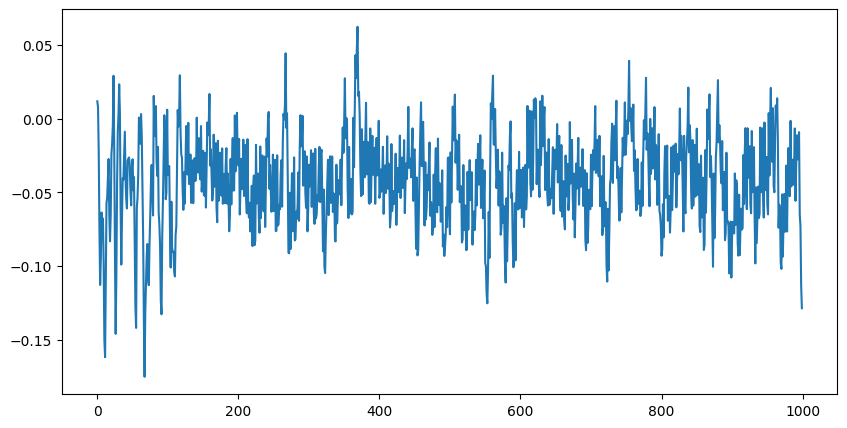

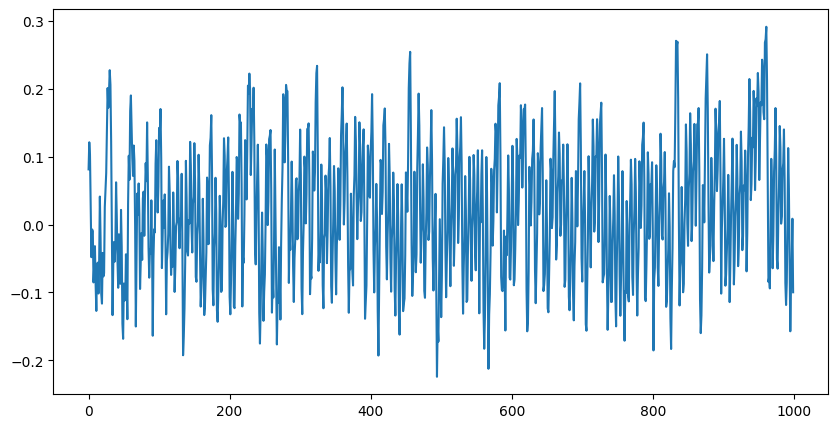

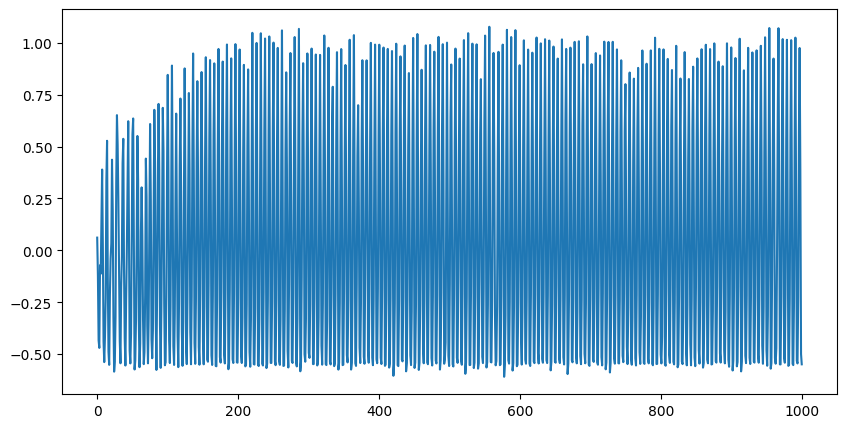

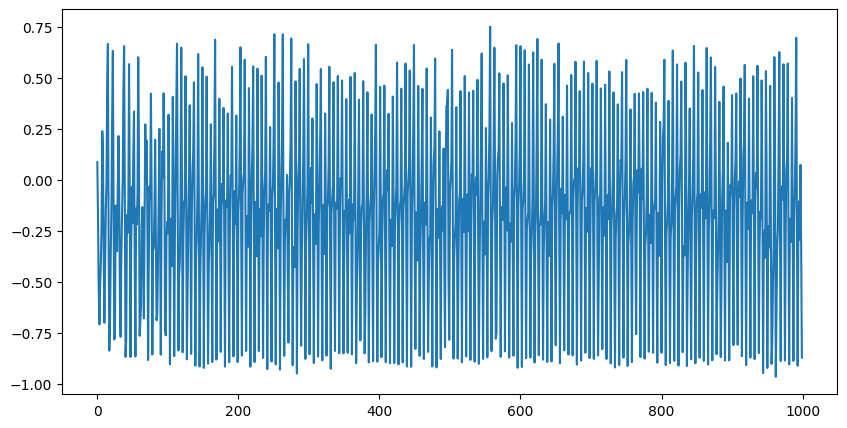

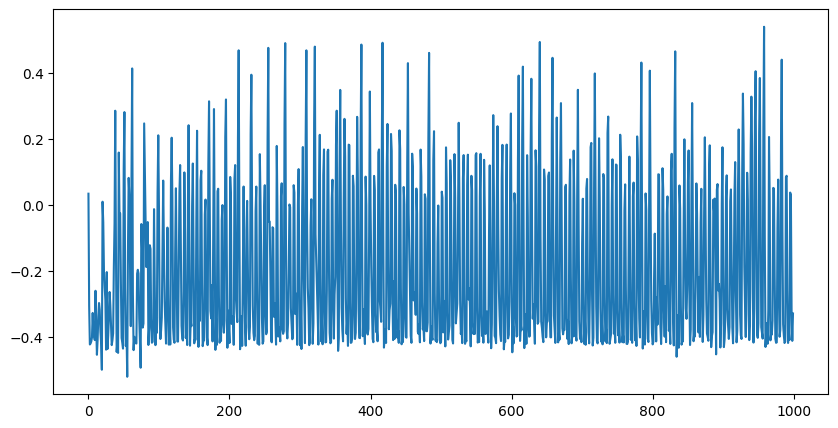

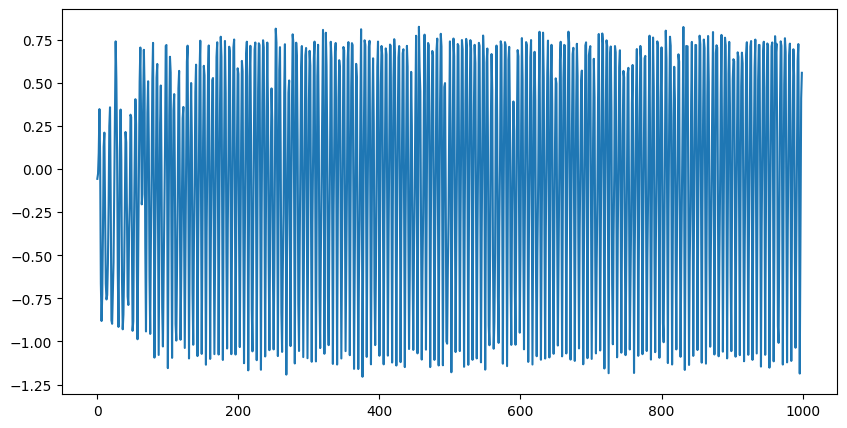

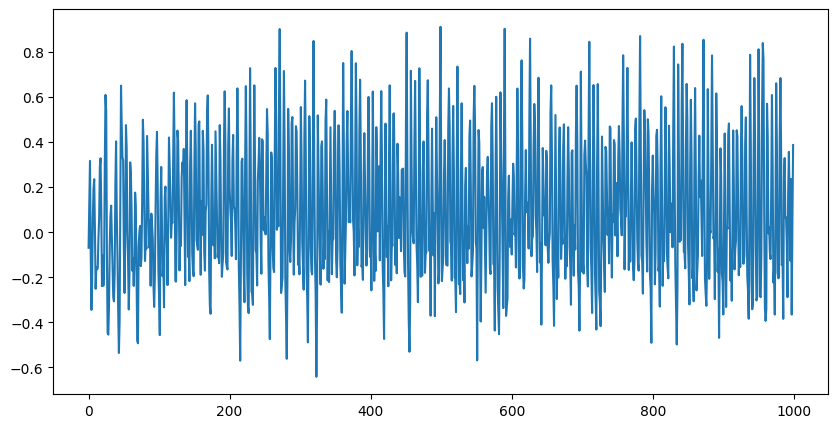

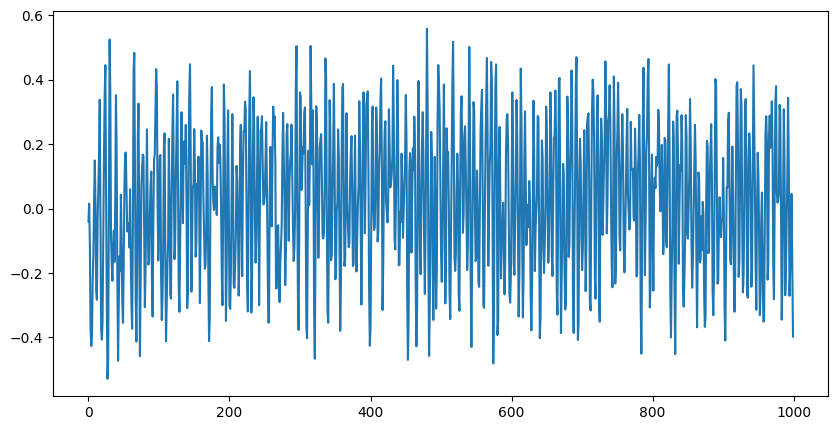

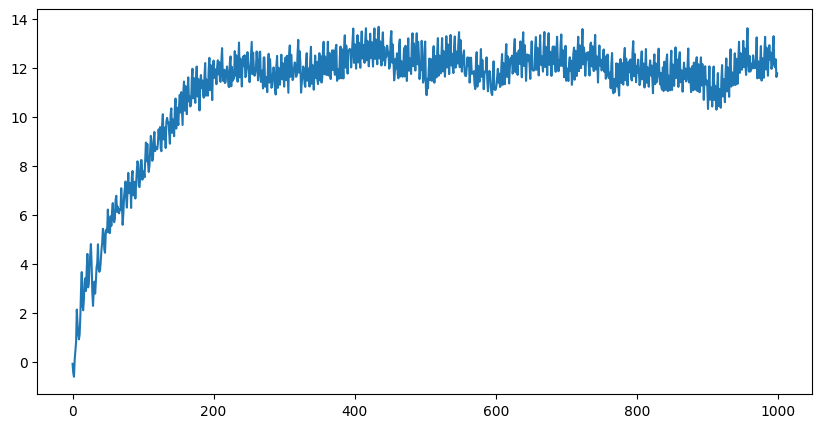

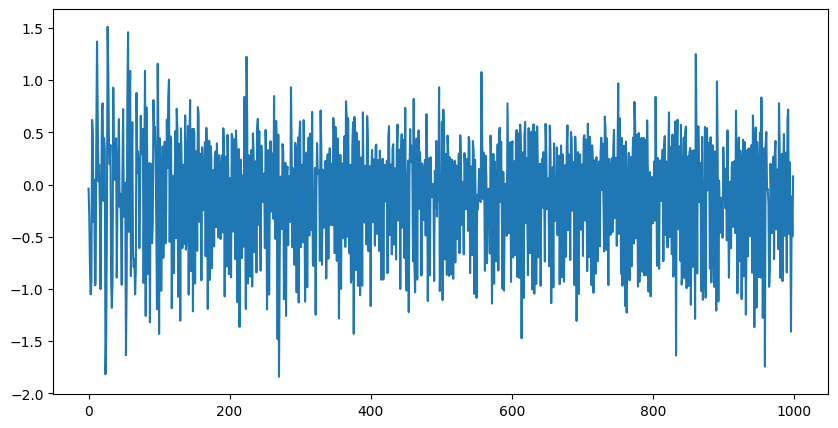

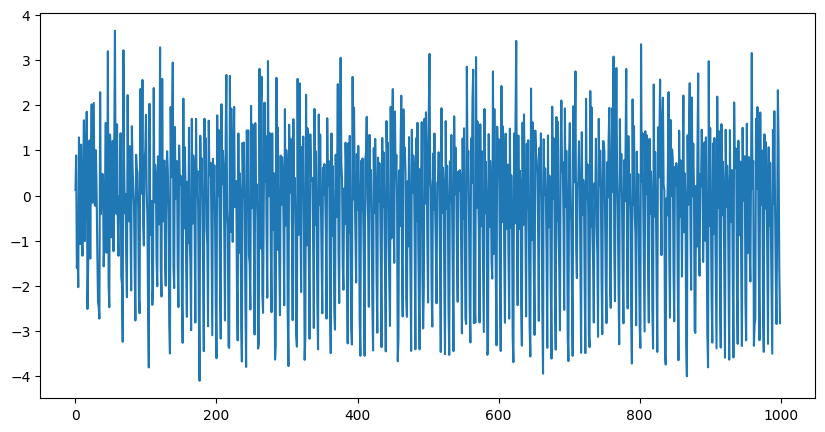

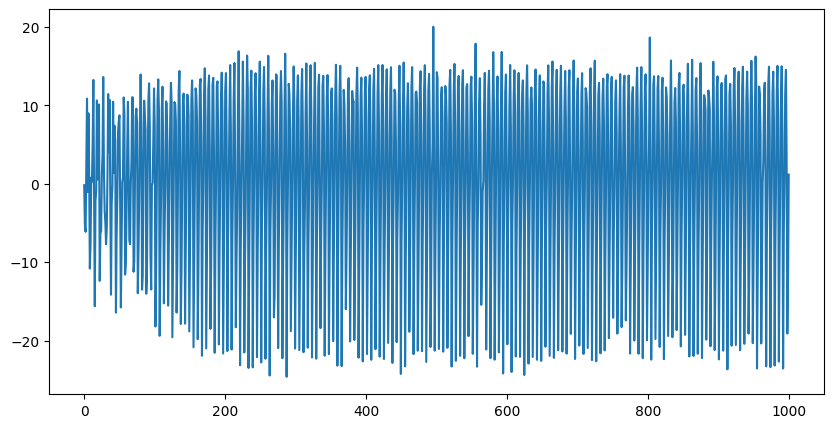

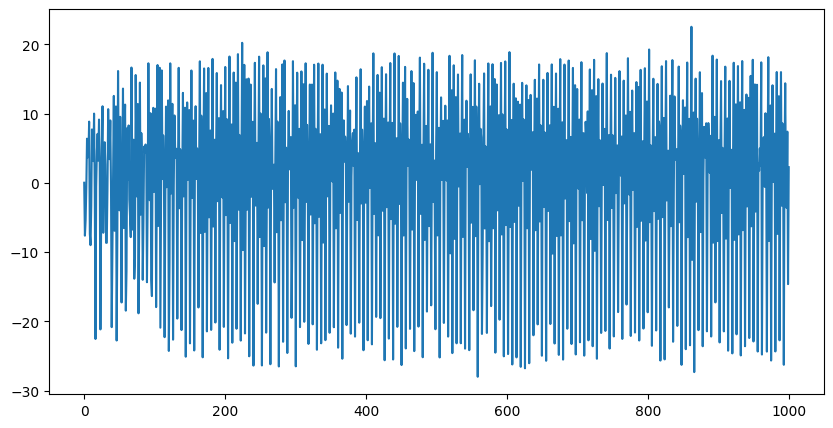

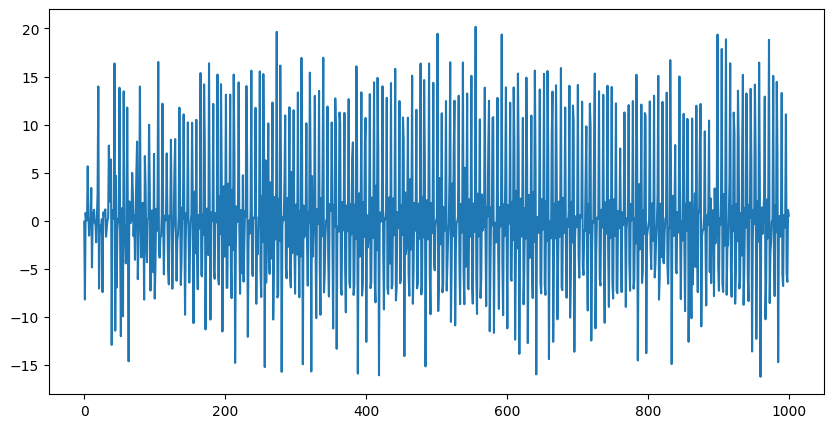

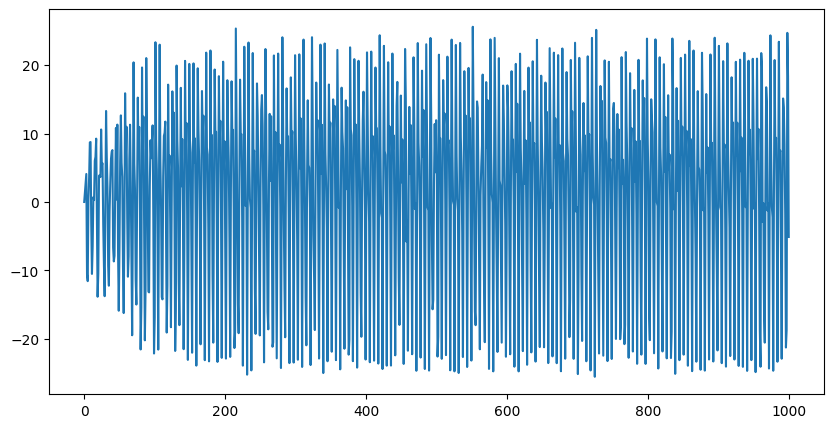

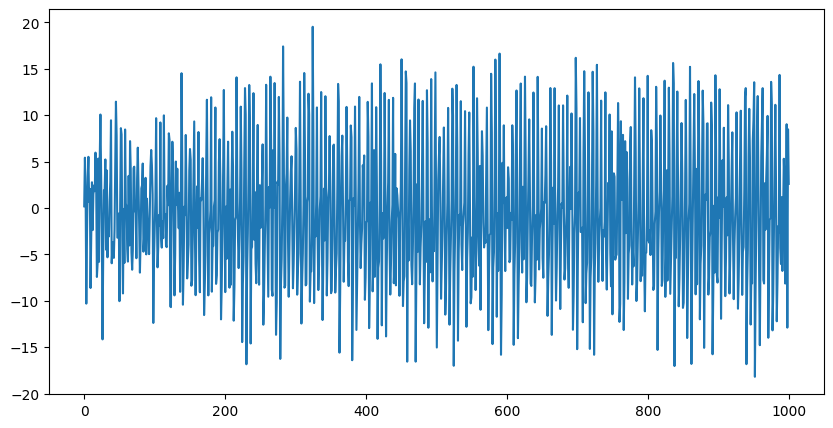

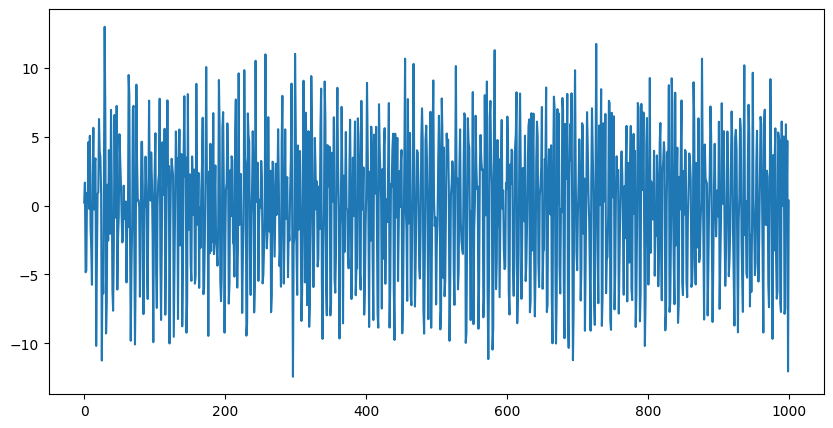

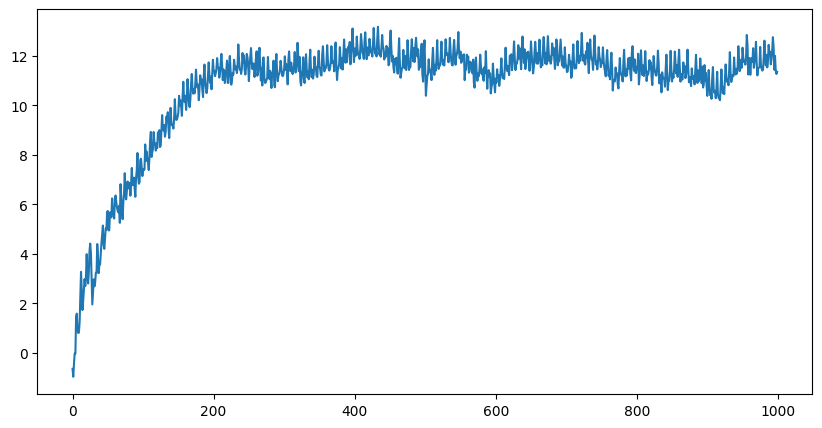

In [20]:
####################################
### Generate continuous time series
####################################

### Halfcheetah + random policy

traj_name = 'gym_halfcheetah_expert'
Nt = 1000 # number of steps

data_path = "/home/abenechehab/d4rl_halfcheetah/d4rl_expert_80k_20k/X_test.csv"
X_test = pd.read_csv(data_path, index_col=0)

episode_time_series = X_test.iloc[:1000,:18].values.astype('float')
        
for obs_dim in range(episode_time_series.shape[1]):
    time_series = episode_time_series[:, obs_dim]
    mean_series = copy(time_series)
    std_series = np.zeros_like(mean_series)
    
    full_series, rescaled_true_mean_arr, rescaled_true_sigma_arr = serialize_gaussian(prec, time_series, mean_series, sigma_series)
    
    plt.figure(figsize=(10, 5))
    plt.plot(time_series, alpha = 1, label=f'time_series dim: {obs_dim}')
    # plt.plot(full_series, alpha = 1, label='full_series')
    
    # Save the generated data to a dictionary
    data_dict = {
        'full_series': full_series,
        'rescaled_true_mean_arr': rescaled_true_mean_arr,
        'rescaled_true_sigma_arr': rescaled_true_sigma_arr,
        'prec': prec,
        'llama_size': llama_size,
        'mode': mode,
        'refine_depth': refine_depth,
        'random_seed': seed,
        'time_series': np.array(time_series)
    }

    # Pickle and save the dictionary
    save_name = os.path.join(save_path, f'{traj_name}_{obs_dim}.pkl')
    with open(save_name, 'wb') as f:
        pickle.dump(data_dict, f)
plt.show()

In [83]:
data_path = "/home/abenechehab/d4rl_halfcheetah/d4rl_expert_80k_20k/X_test.csv"
X_test = pd.read_csv(data_path, index_col=0)
X_test.iloc[:1000,:18].values.astype('float')

array([[ 1.17965108e-02,  8.11828747e-02,  6.15551621e-02, ...,
         1.75695390e-01,  2.09718809e-01, -6.45763934e-01],
       [ 7.67077226e-03,  1.21050984e-01, -1.20094784e-01, ...,
         5.41714811e+00,  1.66222191e+00, -9.66613591e-01],
       [-2.32308879e-02,  1.02679558e-01, -4.33532059e-01, ...,
         1.81753218e+00, -4.84500027e+00, -4.36351031e-01],
       ...,
       [-7.27988556e-02, -5.04703224e-02,  3.90217781e-01, ...,
        -1.28926458e+01,  4.69040871e+00,  1.14306555e+01],
       [-1.13084018e-01,  8.50392040e-03, -4.98980969e-01, ...,
         8.47146606e+00, -1.20364132e+01,  1.12726736e+01],
       [-1.28566369e-01, -9.97852013e-02, -5.48564017e-01, ...,
         2.59265471e+00,  3.51651728e-01,  1.13534193e+01]])

## observations and actions + expert policy

In [10]:
####################################
### Generate continuous time series
####################################

### Halfcheetah + random policy

traj_name = 'gym_halfcheetah_full'
Nt = 1000 # number of steps
seed = 7

data_path = "/home/abenechehab/d4rl_halfcheetah/d4rl_expert_80k_20k/X_test.csv"
X_test = pd.read_csv(data_path, index_col=0)

episode_time_series = X_test.iloc[500:650,:18].values.astype('float')
        
time_series = episode_time_series  #[:, obs_dim]
# concatenate obs time serie with actions at each timestep
time_series = np.concatenate(
    [time_series, X_test.iloc[500:650,18:25].values.astype('float')], 
    axis=1
).flatten()

mean_series = copy(time_series)
std_series = np.zeros_like(mean_series)

full_series, rescaled_true_mean_arr, rescaled_true_sigma_arr = serialize_gaussian(prec, time_series, mean_series, std_series)

# Save the generated data to a dictionary
data_dict = {
    'full_series': full_series,
    'rescaled_true_mean_arr': rescaled_true_mean_arr,
    'rescaled_true_sigma_arr': rescaled_true_sigma_arr,
    'prec': prec,
    'llama_size': llama_size,
    'mode': mode,
    'refine_depth': refine_depth,
    'random_seed': seed,
    'time_series': np.array(time_series)
}

# Pickle and save the dictionary
save_name = os.path.join(save_path, f'{traj_name}.pkl')
with open(save_name, 'wb') as f:
    pickle.dump(data_dict, f)

In [51]:
episode_time_series = X_test.iloc[:1000,:18].values.astype('float')
time_series = episode_time_series[:, obs_dim]
np.concatenate([time_series.reshape((-1, 1)), X_test.iloc[:1000,18:24].values.astype('float')],axis=1)[:2]

array([[ 0.20971881, -0.88973963, -0.83836532, -0.96073818,  0.32482871,
         0.71929038,  0.26706266],
       [ 1.66222191, -0.95263976, -0.99013627, -0.90085137,  0.18636586,
         0.89358407, -0.16360956]])

In [58]:
np.concatenate([time_series.reshape((-1, 1)), X_test.iloc[:1000,18:24].values.astype('float')],axis=1).flatten()[:-6]

array([ 0.20971881, -0.88973963, -0.83836532, ..., -0.96507895,
       -0.64311236,  0.35165173])